# 6章 学習に関するテクニック
本章では、学習の効率化や過学習の対策に関する手法を学びます。

【この章の内容】
- 6.1 パラメータの更新
- 6.2 重みの初期値
- 6.3 Batch Normalization
- 6.4 正則化
- 6.5 ハイパーパラメータの検証
- 6.6 まとめ
<br><br>
まず、この章で利用するライブラリを読み込みます。

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys, os
sys.path.append(os.pardir)
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.layers import *
from common.util import smooth_curve


ModuleNotFoundError: No module named 'dataset'

## 6.1 パラメータの更新

これまで、損失関数の値を小さくするために確率的勾配降下法(stochastic gradient descent)---SGDを用いていました。ここでは、SGDの欠点を確認し、それとは別の最適化手法を学びます。

### 6.1.1 冒険家の話

読んでおいてください。割愛

### 6.1.2 SGD

- 更新式の確認<br>
重みパラメータを$\mathbf{W}$、損失関数を$L$、$\mathbf{W}$についての損失関数の勾配を$\frac{\partial L}{\partial \mathbf{W}}$とすると、SGDは次のように書けます。
$$
\mathbf{W}
    \leftarrow
        \mathbf{W}
            - \eta
                \frac{\partial L}{\partial \mathbf{W}}
\tag{6.1}
$$
$\eta$は学習率です。また、$\leftarrow$は右辺の値で左辺の値を更新することを表しています。

- 実装

In [16]:
# SGDの実装
class SGD:
    
    def __init__(self, lr=0.01):
        self.lr = lr # 学習率
    
    # パラメータの更新メソッド
    def update(self, params, grads): # params,gradsはそれぞれパラメータと勾配が格納されたdict
        for key in params.keys():
            params[key] -= self.lr * grads[key] # 式(6.1)

### 6.1.3 SGDの欠点

次の関数の最小値を求める問題を考える。
$$
f(x, y)
    = \frac{1}{20} x^2
        + y^2
\tag{6.2}
$$

In [17]:
# (6.2)の実装
def function(x, y):
    return x ** 2 / 20 + y ** 2

# (6.2)の勾配を解析的に与える
def df(x, y):
    dx = x / 10.0 # df/dx
    dy = 2.0 * y # df/dy
    return dx, dy


図6-1のように、プロットしてみる。

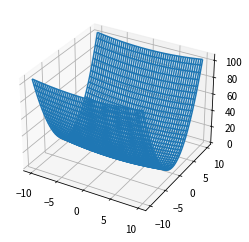

In [18]:
# (6.2)のグラフの描画
fig = plt.figure()
ax = fig.add_subplot(projection='3d') 
x = np.arange(-10.0, 10.0, 0.1)
y = np.arange(-10.0, 10.0, 0.1)
X, Y = np.meshgrid(x, y) # 格子点の作成
Z = function(X, Y)
ax.plot_wireframe(X, Y, Z)
plt.show()

図6-1の等高線

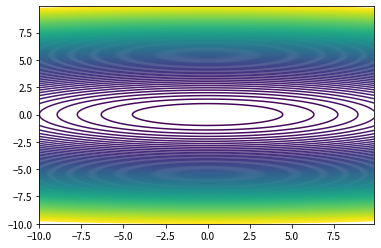

In [19]:
h = np.arange(0., 100.0, 1.0)

plt.figure()
plt.contour(X, Y, Z, levels=h)
plt.show()

図6-2の勾配

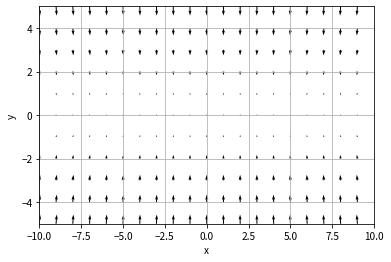

In [20]:
x = np.arange(-10.0, 10.0, 1)
y = np.arange(-10.0, 10.0, 1)
h = np.arange(0, 100.0, 10.0)
X, Y = np.meshgrid(x, y)

X = X.flatten()
Y = Y.flatten()
grad = df(X, Y)

plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy")
plt.xlim([-10, 10])
plt.ylim([-5, 5])
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.draw()
plt.show()

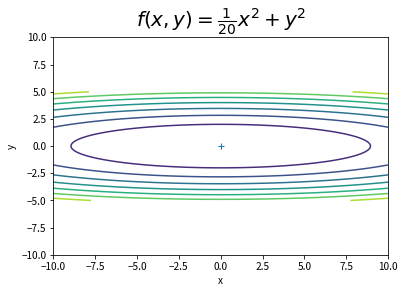

In [23]:
# 等高線用の値
x = np.arange(-10, 10, 0.01)
y = np.arange(-5, 5, 0.01)
X, Y = np.meshgrid(x, y)
Z = function(X, Y)

plt.contour(X, Y, Z) # 等高線
plt.plot(0, 0, '+') # 最小値の点
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xlabel("x") # x軸ラベル
plt.ylabel("y") # y軸ラベル
plt.title("$f(x, y) = \\frac{1}{20} x^2 + y^2$", fontsize=20) # タイトル
plt.show()

この関数の勾配を見てみると、$x$軸方向に小さく、$y$軸方向に大きいことがわかります。それでは、この関数について最小値をSDGによって探索してみましょう。なお、初期値は$(-7,2)$とします。

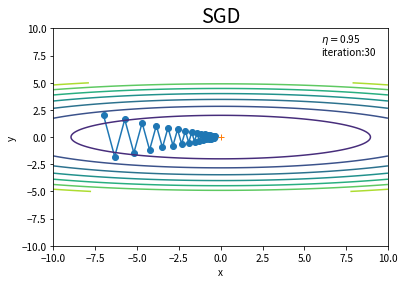

In [33]:
# パラメータの初期値を指定
params = {}
params['x'] = -7.0
params['y'] = 2.0

# 勾配の初期値を指定
grads = {}
grads['x'] = 0
grads['y'] = 0

# 学習率を指定
lr = 0.95

# インスタンスを作成
optimizer = SGD(lr=lr)
# 試行回数を指定
iter_num = 30

# 更新値の記録用リストを初期化
x_history = []
y_history = []

# 初期値を保存
x_history.append(params['x'])
y_history.append(params['y'])

# 関数の最小値を探索
for _ in range(iter_num):
    
    # 勾配を計算
    grads['x'], grads['y'] = df(params['x'], params['y'])
    
    # パラメータを更新
    optimizer.update(params, grads)
    
    # パラメータを記録
    x_history.append(params['x'])
    y_history.append(params['y'])
    
# 作図
plt.plot(x_history, y_history, 'o-') # パラメータの推移
plt.contour(X, Y, Z) # 等高線
plt.plot(0, 0, '+') # 最小値の点
plt.xlim(-10, 10) # x軸の範囲
plt.ylim(-10, 10) # y軸の範囲
plt.xlabel("x") # x軸ラベル
plt.ylabel("y") # y軸ラベル
plt.title("SGD", fontsize=20) # タイトル
plt.text(6, 7.5, "$\\eta=$" + str(lr) + "\n" + "iteration:" + str(iter_num)) # メモ
plt.show()

今回の設定では図のようなジグザグな経路をたどっています。当然、非効率的な探索になっています。これは、最小値に向いていない勾配があることに起因しています。このことより、SGDは等方的な傾きを持たない関数だと、ジグザグな経路を辿る可能性があることがわかります。  
また、学習率や試行回数を変えるとどのような振舞いをするのか試してみます。

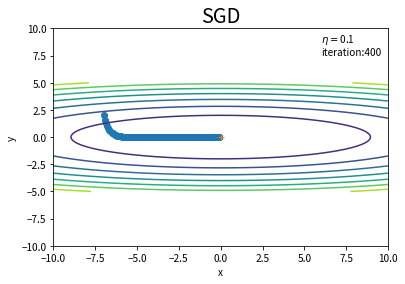

In [40]:
# パラメータの初期値を指定
params = {}
params['x'] = -7.0
params['y'] = 2.0

# 勾配の初期値を指定
grads = {}
grads['x'] = 0
grads['y'] = 0

# 学習率を指定
lr = 0.1

# インスタンスを作成
optimizer = SGD(lr=lr)
# 試行回数を指定
iter_num = 400

# 更新値の記録用リストを初期化
x_history = []
y_history = []

# 初期値を保存
x_history.append(params['x'])
y_history.append(params['y'])

# 関数の最小値を探索
for _ in range(iter_num):
    
    # 勾配を計算
    grads['x'], grads['y'] = df(params['x'], params['y'])
    
    # パラメータを更新
    optimizer.update(params, grads)
    
    # パラメータを記録
    x_history.append(params['x'])
    y_history.append(params['y'])
    
# 作図
plt.plot(x_history, y_history, 'o-') # パラメータの推移
plt.contour(X, Y, Z) # 等高線
plt.plot(0, 0, '+') # 最小値の点
plt.xlim(-10, 10) # x軸の範囲
plt.ylim(-10, 10) # y軸の範囲
plt.xlabel("x") # x軸ラベル
plt.ylabel("y") # y軸ラベル
plt.title("SGD", fontsize=20) # タイトル
plt.text(6, 7.5, "$\\eta=$" + str(lr) + "\n" + "iteration:" + str(iter_num)) # メモ
plt.show()

もちろん学習率を小さくすると経路は改善されますが、その分所要計算回数は大きくなります。

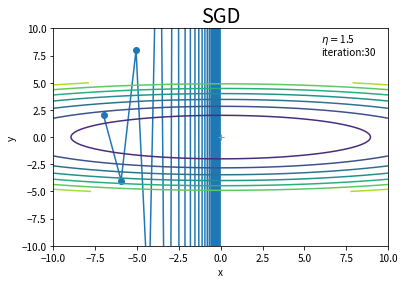

In [41]:
# パラメータの初期値を指定
params = {}
params['x'] = -7.0
params['y'] = 2.0

# 勾配の初期値を指定
grads = {}
grads['x'] = 0
grads['y'] = 0

# 学習率を指定
lr = 1.5

# インスタンスを作成
optimizer = SGD(lr=lr)
# 試行回数を指定
iter_num = 30

# 更新値の記録用リストを初期化
x_history = []
y_history = []

# 初期値を保存
x_history.append(params['x'])
y_history.append(params['y'])

# 関数の最小値を探索
for _ in range(iter_num):
    
    # 勾配を計算
    grads['x'], grads['y'] = df(params['x'], params['y'])
    
    # パラメータを更新
    optimizer.update(params, grads)
    
    # パラメータを記録
    x_history.append(params['x'])
    y_history.append(params['y'])
    # 作図
plt.plot(x_history, y_history, 'o-') # パラメータの推移
plt.contour(X, Y, Z) # 等高線
plt.plot(0, 0, '+') # 最小値の点
plt.xlim(-10, 10) # x軸の範囲
plt.ylim(-10, 10) # y軸の範囲
plt.xlabel("x") # x軸ラベル
plt.ylabel("y") # y軸ラベル
plt.title("SGD", fontsize=20) # タイトル
plt.text(6, 7.5, "$\\eta=$" + str(lr) + "\niteration:" + str(iter_num)) # メモ
plt.show()

また、学習率を大きくすると、発散してしまいます。

### 6.1.4 Momentum

Momentumとは運動量という意味の言葉です。物理では、運動方程式
$$
\boldsymbol{F}
    = \frac{d\boldsymbol{p}}{dt}
$$
にあらわれる、$\boldsymbol{p}(=m\boldsymbol{v})$です。
では、手法を確認します。
- 更新式
$$
\mathbf{v}
    \leftarrow
      \alpha \mathbf{v}
      - \eta
        \frac{\partial L}{\partial \mathbf{W}}
\tag{6.3}
$$
$$
\mathbf{W}
    \leftarrow
      \mathbf{W} + \mathbf{v}
\tag{6.4}
$$

これだけでは少しわかりづらいため、まず、初回の更新について考えます。初回の更新は$\mathbf{v}^{(1)} = \alpha \mathbf{v}^{(0)} - \eta \frac{\partial L}{\partial \mathbf{W}^{(0)}}$と表せます。また、$\mathbf{v}^{(0)}$を$0$とすると、
$$
\mathbf{v}^{(1)}
    = - \eta
        \frac{\partial L}{\partial \mathbf{W}^{(0)}}
$$

になります。

次に2回目の更新を考えます。二回目の更新は$\mathbf{v}^{(2)} = \alpha \mathbf{v}^{(1)} - \eta \frac{\partial L}{\partial \mathbf{W}^{(1)}}$と書けるのでこれに$\mathbf{v}^{(1)}$を代入すると、
$$
\mathbf{v}^{(2)}
    = - \alpha \eta
        \frac{\partial L}{\partial \mathbf{W}^{(0)}}
      - \eta
        \frac{\partial L}{\partial \mathbf{W}^{(1)}}
$$

となります。これを同様に繰り返し、$T$回目の更新を求めると、
$$
\begin{align*}
\mathbf{W}^{(T)}
   &= \mathbf{W}^{(T-1)} + \mathbf{v}^{(T)}
\\
   &= \mathbf{W}^{(T-1)}
      - \eta
        \sum_{t=1}^T
          \alpha^{T-t}
          \frac{\partial L}{\partial \mathbf{W}^{(t-1)}}
\end{align*}
$$
となります。\
つまり、Momentumでは、過去の勾配の情報を$\mathbf{v}$として保持しています。そのため、関数(6.2)のような$x$軸方向の勾配が小さくても、更新するにしたがって徐々に足されていき、その重みは大きくなります。もちろん、$y$軸方向のほうが大きい勾配を持っていますが、正と負の方向で交互に足されることにより、互いに打ち消し合うことにより、その重みは小さくなっていきます。
- 実装

In [43]:
# Momentumの実装
class Momentum:
    
    # インスタンス変数を定義
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr # 学習率
        self.momentum = momentum # vの調整項
        self.v = None # 速度
    
    # パラメータの更新メソッドを定義
    def update(self, params, grads):
        # vを初期化
        if self.v is None: # 初回のみ
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val) # 全ての要素が0
        
        # パラメータごとに値を更新
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key] # 式(6.3)
            params[key] += self.v[key] # 式(6.4)

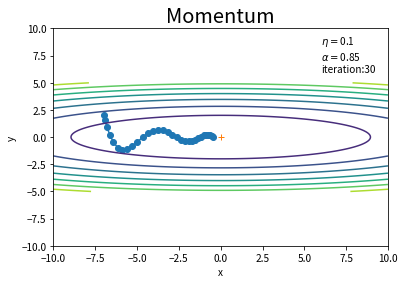

In [58]:
# パラメータの初期値を指定
params = {}
params['x'] = -7.0
params['y'] = 2.0

# 勾配の初期値を指定
grads = {}
grads['x'] = 0
grads['y'] = 0

# 学習率を指定
lr = 0.1

# モーメンタムを指定
momentum = 0.85

# インスタンスを作成
optimizer = Momentum(lr=lr, momentum=momentum)

# 試行回数を指定
iter_num = 30

# 更新値の記録用リストを初期化
x_history = []
y_history = []

# 初期値を保存
x_history.append(params['x'])
y_history.append(params['y'])

# 関数の最小値を探索
for _ in range(iter_num):
    
    # 勾配を計算
    grads['x'], grads['y'] = df(params['x'], params['y'])
    
    # パラメータを更新
    optimizer.update(params, grads)
    
    # パラメータを記録
    x_history.append(params['x'])
    y_history.append(params['y'])
    
# 作図
plt.plot(x_history, y_history, 'o-') # パラメータの推移
plt.contour(X, Y, Z) # 等高線
plt.plot(0, 0, '+') # 最小値の点
plt.xlim(-10, 10) # x軸の範囲
plt.ylim(-10, 10) # y軸の範囲
plt.xlabel("x") # x軸ラベル
plt.ylabel("y") # y軸ラベル
plt.title("Momentum", fontsize=20) # タイトル
plt.text(6, 6, "$\\eta=$" + str(lr) + "\n$\\alpha=$" + str(momentum) + "\niteration:" + str(iter_num)) # メモ
plt.show()

### 6.1.5 AdaGrad

学習率について、これまで見てきた通り、小さすぎると計算量が大きくなり、大きすぎると発散してしまうという悩ましい問題があります。AdaGradはこの問題を解決するべく各要素ごとに適応的に学習率を調節しながらできる手法です。
- 更新式
$$
\mathbf{h}
    \leftarrow
      \mathbf{h}
      + \frac{\partial L}{\partial \mathbf{W}}
        \odot \frac{\partial L}{\partial \mathbf{W}}
\tag{6.5}
$$
$$
\mathbf{W}
    \leftarrow
      \mathbf{W}
      - \eta
        \frac{1}{\sqrt{\mathbf{h}}}
        \frac{\partial L}{\partial \mathbf{W}}
\tag{6.6}
$$
ここで$\odot$は行列の要素毎の乗算を意味します。
先ほどと同様にT回目の更新を考えてみます。例として$j,k$成分について考えてみます。
$$
\begin{align*}
h_{jk}^{(1)}
    &= \Bigl(
          \frac{\partial L}{\partial w_{jk}^{(0)}}
      \Bigr)^2
\\
h_{jk}^{(2)}
    &= \Bigl(
          \frac{\partial L}{\partial w_{jk}^{(0)}}
      \Bigr)^2
      + \Bigl(
          \frac{\partial L}{\partial w_{jk}^{(1)}}
      \Bigr)^2
\\
\dots
\\
h_{jk}^{(T)}
   &= \Bigl(
          \frac{\partial L}{\partial w_{jk}^{(0)}}
      \Bigr)^2
      + \Bigl(
          \frac{\partial L}{\partial w_{jk}^{(1)}}
      \Bigr)^2
      + \cdots
      + \Bigl(
          \frac{\partial L}{\partial w_{jk}^{(T-1)}}
      \Bigr)^2
\\
   &= \sum_{t=1}^T
          \Bigl(
              \frac{\partial L}{\partial w_{jk}^{(t-1)}}
          \Bigr)^2
\end{align*}
$$
これを用いて、$w_{jk}$の$T$更新値は、
$$
\begin{align*}
w_{jk}^{(T)}
   &= w_{jk}^{(T-1)}
      - \eta
        \frac{1}{\sqrt{h_{jk}^{(T)}}}
        \frac{\partial L}{\partial w_{jk}^{(T-1)}}
\\
   &= w_{jk}^{(T-1)}
      - \eta
        \frac{
            1
        }{
            \sqrt{
                \sum_{t=1}^T
                    \Bigl(\frac{\partial L}{\partial w_{jk}^{(t-1)}}\Bigr)^2
            }
        }
        \frac{\partial L}{\partial w_{jk}^{(T-1)}}
\end{align*}
$$
となります。
- 実装

In [60]:
# AdaGradの実装
class AdaGrad:
    
    # インスタンス変数を定義
    def __init__(self, lr=0.01):
        self.lr = lr # 学習率
        self.h = None # 過去の勾配の2乗和
    
    # パラメータの更新メソッドを定義
    def update(self, params, grads):
        # hの初期化
        if self.h is None: # 初回のみ
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val) # 全ての要素が0
        
        # パラメータごとに値を更新
        for key in params.keys():
            self.h[key] += grads[key] * grads[key] # 式(6.5)
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) # 式(6.6)

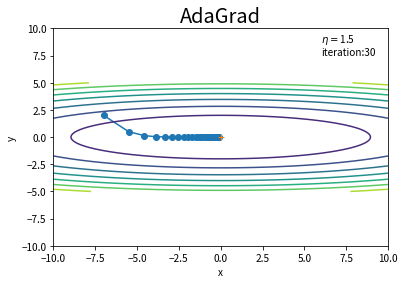

In [61]:
# パラメータの初期値を指定
params = {}
params['x'] = -7.0
params['y'] = 2.0

# 勾配の初期値を指定
grads = {}
grads['x'] = 0
grads['y'] = 0

# 学習率を指定
lr = 1.5

# インスタンスを作成
optimizer = AdaGrad(lr=lr)
# 試行回数を指定
iter_num = 30

# 更新値の記録用リストを初期化
x_history = []
y_history = []

# 初期値を保存
x_history.append(params['x'])
y_history.append(params['y'])

# 関数の最小値を探索
for _ in range(iter_num):
    
    # 勾配を計算
    grads['x'], grads['y'] = df(params['x'], params['y'])
    
    # パラメータを更新
    optimizer.update(params, grads)
    
    # パラメータを記録
    x_history.append(params['x'])
    y_history.append(params['y'])
    
# 作図
plt.plot(x_history, y_history, 'o-') # パラメータの推移
plt.contour(X, Y, Z) # 等高線
plt.plot(0, 0, '+') # 最小値の点
plt.xlim(-10, 10) # x軸の範囲
plt.ylim(-10, 10) # y軸の範囲
plt.xlabel("x") # x軸ラベル
plt.ylabel("y") # y軸ラベル
plt.title("AdaGrad", fontsize=20) # タイトル
plt.text(6, 7.5, "$\\eta=$" + str(lr) + "\niteration:" + str(iter_num)) # メモ
plt.show()

### 6.1.6 Adam

AdamはMomentumとAdaGradのアイデアを合わせたような手法です。
- 更新式
$$
\mathbf{m}
    \leftarrow
      \beta_1 \mathbf{m}
      + (1 - \beta_1)
        \frac{\partial L}{\partial \mathbf{W}}
\tag{1}
$$
$$
\mathbf{v}
    \leftarrow
      \beta_2 \mathbf{v}
      + (1 - \beta_2)
        \frac{\partial L}{\partial \mathbf{W}}
        \odot \frac{\partial L}{\partial \mathbf{W}}
\tag{2}
$$
$$
\begin{align}
\hat{\mathbf{m}}
   &= \frac{\mathbf{m}}{1 - \beta_1^t}
\tag{3}\\
\hat{\mathbf{v}}
   &= \frac{\mathbf{v}}{1 - \beta_2^t}
\tag{4}
\end{align}
$$
$$
\mathbf{W}
    \leftarrow
      - \eta
        \frac{
            \hat{\mathbf{m}}
        }{
            \sqrt{\hat{\mathbf{v}}} + \epsilon
        }
\tag{5}
$$
$$
\mathbf{W}
    \leftarrow
      \mathbf{W}
      - \eta
        \frac{\sqrt{1 - \beta_2^t}}{1 - \beta_1^t}
        \frac{\mathbf{m}}{\sqrt{\mathbf{v}} + \epsilon}
\tag{6}
$$

- 実装

In [19]:
# Adamの実装
class Adam:

    # インスタンス変数を定義
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr # 学習率
        self.beta1 = beta1 # mの減衰率
        self.beta2 = beta2 # vの減衰率
        self.iter = 0 # 試行回数を初期化
        self.m = None # モーメンタム
        self.v = None # 適合的な学習係数
    
    # パラメータの更新メソッドを定義
    def update(self, params, grads):
        # mとvを初期化
        if self.m is None: # 初回のみ
            self.m = {}
            self.v = {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val) # 全ての要素が0
                self.v[key] = np.zeros_like(val) # 全ての要素が0
        
        # パラメータごとに値を更新
        self.iter += 1 # 更新回数をカウント
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2 ** self.iter) / (1.0 - self.beta1 ** self.iter) # 式(6)の学習率の項
        for key in params.keys():
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key] # 式(1)
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key] ** 2) # 式(2)
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7) # 式(6)

In [20]:
# パラメータの初期値を指定
params = {}
params['x'] = -7.0
params['y'] = 2.0

# 勾配の初期値を指定
grads = {}
grads['x'] = 0
grads['y'] = 0

# 学習率を指定
lr = 0.3

# 減衰率を指定
beta1 = 0.9
beta2 = 0.999

# インスタンスを作成
optimizer = Adam(lr=lr, beta1=beta1, beta2=beta2)


In [21]:
# 試行回数を指定
iter_num = 30

# 更新値の記録用リストを初期化
x_history = []
y_history = []

# 初期値を保存
x_history.append(params['x'])
y_history.append(params['y'])

# 関数の最小値を探索
for _ in range(iter_num):
    
    # 勾配を計算
    grads['x'], grads['y'] = df(params['x'], params['y'])
    
    # パラメータを更新
    optimizer.update(params, grads)
    
    # パラメータを記録
    x_history.append(params['x'])
    y_history.append(params['y'])

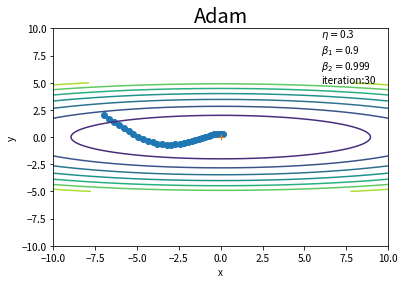

In [22]:
# 作図
plt.plot(x_history, y_history, 'o-') # パラメータの推移
plt.contour(X, Y, Z) # 等高線
plt.plot(0, 0, '+') # 最小値の点
plt.xlim(-10, 10) # x軸の範囲
plt.ylim(-10, 10) # y軸の範囲
plt.xlabel("x") # x軸ラベル
plt.ylabel("y") # y軸ラベル
plt.title("Adam", fontsize=20) # タイトル
plt.text(6, 5, "$\\eta=$" + str(lr) + "\n$\\beta_1=$" + str(beta1) + 
         "\n$\\beta_2=$" + str(beta2) + "\niteration:" + str(iter_num)) # メモ
plt.show()

### 6.1.7 どの更新手法を用いるか？

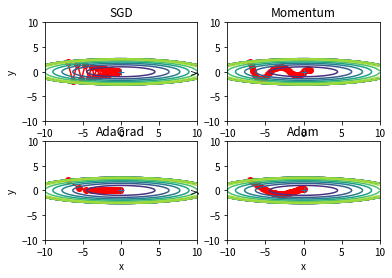

In [23]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *

def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

### 6.1.8 MNISTデータセットによる更新手法の比較

In [24]:
# この項で利用するライブラリを読み込む
import numpy as np
import matplotlib.pyplot as plt

# データ読み込み用ライブラリを読み込む
import sys, os

# ファイルパスを指定
sys.path.append(os.pardir)

# MNISTデータセット読み込み関数を読み込む
from dataset.mnist import load_mnist

# 多層ニューラルネットワーククラスを読み込む
from common.multi_layer_net import MultiLayerNet

# 画像データを読み込む
(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True, one_hot_label=True)
print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [25]:
# 訓練データ数
train_size = x_train.shape[0]

# バッチサイズ指定
batch_size = 128

# 試行回数を指定
max_iterations = 2001

In [26]:
# 各手法のインスタンスをディクショナリ変数に格納
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
print(optimizers.keys())

dict_keys(['SGD', 'Momentum', 'AdaGrad', 'Adam'])


In [27]:
# 手法ごとにディクショナリ変数に格納
networks = {}
train_loss = {}
for key in optimizers.keys():
    # 多層ニューラルネットワーク
    networks[key] = MultiLayerNet(
        input_size=784, 
        hidden_size_list=[100, 100, 100, 100],
        output_size=10
    )
    
    # 交差エントロピー誤差の受け皿
    train_loss[key] = []

In [28]:
# 手書き文字認識
for i in range(max_iterations):
    # ランダムにバッチデータ抽出
    batch_mask = np.random.choice(train_size, batch_size, replace=False)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 手法ごとに学習
    for key in optimizers.keys():
        # 勾配を計算
        grads = networks[key].gradient(x_batch, t_batch)
        
        # パラメータを更新
        optimizers[key].update(networks[key].params, grads)
        
        # 損失関数の計算
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss) # 交差エントロピー誤差を記録
    
    # (動作確認も兼ねて)100回ごとに損失関数の値を表示
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            print(
                key + " " * (8 - len(key)) + ":" + # (`8`は`key`の最大文字数)
                str(np.round(train_loss[key][i], 5))
            )

===========iteration:0===========
SGD     :2.30219
Momentum:2.35205
AdaGrad :2.25226
Adam    :2.13388
===========iteration:100===========
SGD     :1.71328
Momentum:0.31382
AdaGrad :0.16906
Adam    :0.23856
===========iteration:200===========
SGD     :0.88024
Momentum:0.25775
AdaGrad :0.07674
Adam    :0.23755
===========iteration:300===========
SGD     :0.56237
Momentum:0.20126
AdaGrad :0.07198
Adam    :0.11149
===========iteration:400===========
SGD     :0.38169
Momentum:0.1645
AdaGrad :0.0559
Adam    :0.14031
===========iteration:500===========
SGD     :0.4317
Momentum:0.17255
AdaGrad :0.0807
Adam    :0.11378
===========iteration:600===========
SGD     :0.2998
Momentum:0.18594
AdaGrad :0.09173
Adam    :0.15566
===========iteration:700===========
SGD     :0.33275
Momentum:0.10072
AdaGrad :0.04496
Adam    :0.0719
===========iteration:800===========
SGD     :0.31172
Momentum:0.08401
AdaGrad :0.05536
Adam    :0.06331
===========iteration:900===========
SGD     :0.27085
Momentum:0.07586
Ad

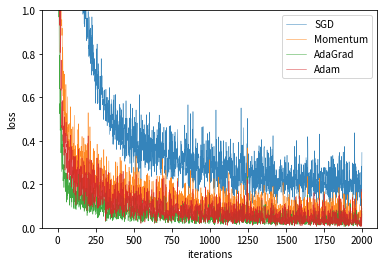

In [29]:
# 作図用のx軸の点
iterations = np.arange(max_iterations)

# 作図
for key in optimizers.keys():
    plt.plot(iterations, train_loss[key], label=key, linewidth=0.5, alpha=0.9)
plt.xlabel("iterations") # x軸ラベル
plt.ylabel("loss") # y軸ラベル
plt.ylim(0, 1) # y軸の範囲
plt.legend() # 凡例
plt.show()

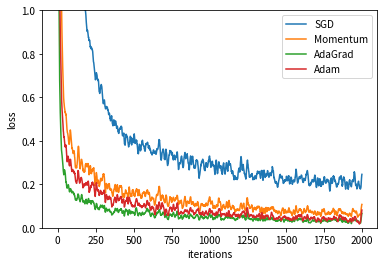

In [30]:
# 作図用のx軸の点
iterations = np.arange(max_iterations)

# 作図
for key in optimizers.keys():
    plt.plot(iterations, smooth_curve(train_loss[key]), label=key)
plt.xlabel("iterations") # x軸ラベル
plt.ylabel("loss") # y軸ラベル
plt.ylim(0, 1) # y軸の範囲
plt.legend() # 凡例
plt.show()

## 6.2 重みの初期値

学習の成否に大きくかかわる重みの初期値について考えます。

### 6.2.1 重みの初期値を0にする？

### 6.2.2 隠れ層のアクティベーション分布

ここでは重みの初期値の影響を見るために、活性化関数からの出力データ(＝アクティベーション)の分布を観察します。実験として、隠れ層を5層にして、それぞれの層は100個のニューロンを持つものとします。活性化関数をシグモイド関数として設定します。

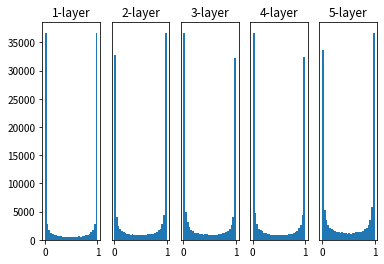

In [31]:
#シグモイド関数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000,100)
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) * 1 #標準偏差=1
    z = np.dot(x, w)
    a = sigmoid(z)
    activations[i] = a

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

すべての層で0、1に偏ったアクティベーションの分布になっています。シグモイド関数は0、1で微分が0に近づくため逆伝播での勾配の値が小さくなって消えてしまいます。これを$\bf{勾配消失}$といいます。\
では、標準偏差を変えて同じを実験してみます。

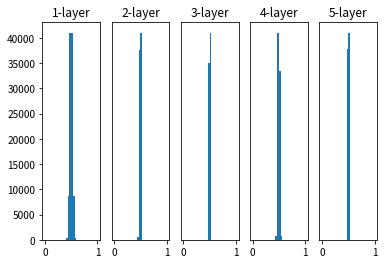

In [32]:
x = np.random.randn(1000,100)
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) * 0.01 #標準偏差=0.01
    z = np.dot(x, w)
    a = sigmoid(z)
    activations[i] = a
# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

標準偏差を0.01とした場合どの層も0.5付近に偏る分布になりました。勾配消失の問題は生じませんが、これでは各層ですべてのニューロンが同じ値を出力することになり、表現力に問題が生じます。\
その問題を解決すべく、ここで「Xavierの初期値」というものを導入します。Xavierの初期値とは、前層のノード数を$n$とすると$\frac{1}{\sqrt{n}}$の標準偏差を持つ分布に従う初期値のことです。

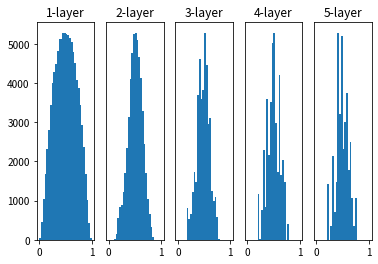

In [33]:
x = np.random.randn(1000,100)
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num) #標準偏差=sqrt(1/n)=0.1
    z = np.dot(x, w)
    a = sigmoid(z)
    activations[i] = a
# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

これまでよりも広がりを持った分布になりました。

### 6.2.3 ReLUの場合の重みの初期化

次は活性化関数にReLU関数を用いる場合を確認します。

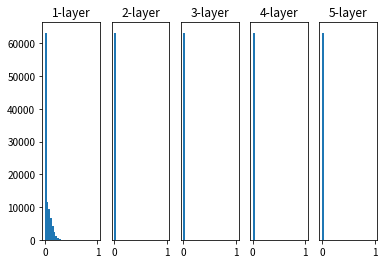

In [34]:
# ReLU関数
def relu(x):
    return np.maximum(0, x)

x = np.random.randn(1000,100)
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) * 0.01 #標準偏差=0.01
    z = np.dot(x, w)
    a = relu(z)
    activations[i] = a
# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

ReLU関数は負の値が全て0になるため0が多くなるのは当然の結果ですが、0以外の値がほとんど現れていません。続いて「Xavierの初期値」の結果を見てみます。

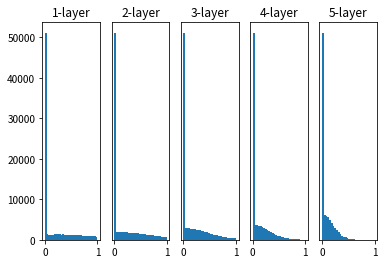

In [35]:
x = np.random.randn(1000,100)
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num) #標準偏差=sqrt(1/n)=0.1
    z = np.dot(x, w)
    a = relu(z)
    activations[i] = a
# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

第1層の出力時は値が均一に分布していますが、層が進むごとに小さい値に分布が偏っていきます。そこでReLU関数には「Heの初期値」と呼ばれる初期値を用いてみます。これは前層のノード数を$n$とすると$\frac{2}{\sqrt{n}}$の標準偏差を持つ分布に従う初期値のことです。

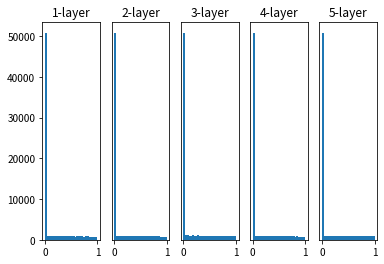

In [36]:
x = np.random.randn(1000,100)
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num) # Heの初期値
    z = np.dot(x, w)
    a = relu(z)
    activations[i] = a
# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

各層のアクティベーションの分布は均一になりました。

### 6.2.4 MNISTデータセットによる重み初期値の比較

ここでは、3種類の重みの初期値の与え方によって、学習(交差エントロピー誤差推移)にどのように影響するのかを確認します。活性化関数はReLUを使用します。

===========iteration:0===========
std=0.01:2.302483697319613
Xavier:2.307118770610086
He:2.4355795399771623
===========iteration:100===========
std=0.01:2.3018963721043404
Xavier:2.24198529261598
He:1.4542515734739228
===========iteration:200===========
std=0.01:2.3030555762253266
Xavier:2.096318742754618
He:0.7563115685725301
===========iteration:300===========
std=0.01:2.3053524911741183
Xavier:1.7862181596592115
He:0.5743345476252453
===========iteration:400===========
std=0.01:2.298809659504835
Xavier:1.3145442036766912
He:0.5085075580108004
===========iteration:500===========
std=0.01:2.3019889751894755
Xavier:0.9993650406301026
He:0.4740567876619723
===========iteration:600===========
std=0.01:2.300509264903342
Xavier:0.830306149068688
He:0.40131633804972494
===========iteration:700===========
std=0.01:2.299658063708491
Xavier:0.6282989587033623
He:0.41852339880577494
===========iteration:800===========
std=0.01:2.3019423085908475
Xavier:0.46082350538215133
He:0.2441700739283361


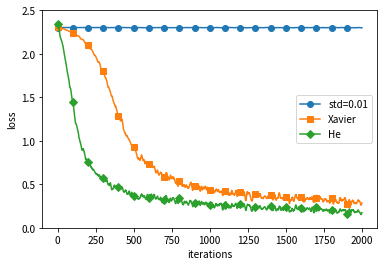

In [37]:
# MNISTデータの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True, one_hot_label=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

# ディクショナリを作成
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []

for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

## 6.3 Batch Normalization

前節では重みの初期値の設定の工夫によりアクティベーションの分布の広がりを保つ手法を学びました。ここではアクティベーションに工夫を加えることで分布を調節する手法を考えます。

### 6.3.1 Batch Normalizationのアルゴリズム

Batch Normとはミニバッチごとに標準化することです。ミニバッチデータの分布が平均が0で標準偏差が1になるようにすることです。Batch Normには次の利点があります。
- 学習を速く進行させられる
- 初期値にそれほど依存しない
- 過学習を抑制する

では、アルゴリズムを確認します。データ数が
$m$のミニバッチデータを$B = \{x_1, x_2, \cdots, x_m\}$とすると、次の式で表せます。
$$
\begin{align*}
\mu_B
   &\leftarrow
      \frac{1}{m}
      \sum_{i=1}^m
          x_i
\\
\sigma_B^2
   &\leftarrow
      \frac{1}{m}
      \sum_{i=1}^m
          (x_i - \mu_B)^2
\\
\hat{x}_i
   &\leftarrow
      \frac{
          x_i - \mu_B
      }{
          \sqrt{\sigma_B^2 + \epsilon}
      }
\tag{6.7}
\end{align*}
$$
なお$\epsilon$0で割ることを防止するための微小な値です。これは、ミニバッチ毎に標準化を行っています。さらに、Batch Normでは、この標準化されたデータ$\{\hat{x}_1, \hat{x}_2, \cdots, \hat{x}_m\}$に対して次の変換を行います。
$$
y_i \leftarrow
      \gamma \hat{x}_i + \beta
\tag{6.8}
$$
ここで、$\beta$と$\gamma$はパラメータで、学習によって最適化していきます。

### 6.3.2 Batch Normalizationの評価

In [38]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True, one_hot_label=True)
# 学習データを削減
x_train = x_train[:1000]
t_train = t_train[:1000]

# 訓練データ数
train_size = x_train.shape[0]

# バッチサイズを指定
batch_size = 100
# 重みの初期値の標準偏差を指定
weight_init_std = 0.05

# Batch Normレイヤを含む5層のニューラルネットワークのインスタンスを作成
bn_network = MultiLayerNetExtend(
    input_size=784, 
    hidden_size_list=[100, 100, 100, 100, 100], 
    output_size=10, 
    activation='relu', # 活性化関数
    weight_init_std=weight_init_std, # 重みの初期値の標準偏差
    use_batchnorm=True # Batch Normalizationの設定
)

# Batch Normレイヤを含まない5層のニューラルネットワークのインスタンスを作成
network = MultiLayerNetExtend(
    input_size=784, 
    hidden_size_list=[100, 100, 100, 100, 100], 
    output_size=10,
    activation='relu', # 活性化関数
    weight_init_std=weight_init_std, # 重みの初期値の標準偏差
    use_batchnorm=False # Batch Normalizationの設定
)

# 最適化手法を指定
optimizer = SGD(lr=0.01)
# 試行するエポック数を指定
max_epochs = 20

# 全データ数に対するバッチデータ数の割合(エポック数判定用)
iter_per_epoch = max(train_size / batch_size, 1)

# 試行エポック数を初期化
epoch_cnt = 0

# 認識精度の受け皿を初期化
bn_train_acc_list = []
train_acc_list = []

# 手書き文字認識
for i in range(1000000000):
    
    # ランダムにバッチデータを抽出
    batch_mask = np.random.choice(train_size, batch_size, replace=False)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # Batch Normレイヤありver.なしver.を切り替え
    for _network in (bn_network, network):
        
        # 勾配を計算
        grads = _network.gradient(x_batch, t_batch)
        
        # パラメータを更新
        optimizer.update(_network.params, grads)
    
    # エポックごとに認識精度を測定
    if i % iter_per_epoch == 0:
        # 認識精度を測定
        bn_train_acc = bn_network.accuracy(x_train, t_train)
        train_acc = network.accuracy(x_train, t_train)
        
        # 値を記録
        bn_train_acc_list.append(bn_train_acc)
        train_acc_list.append(train_acc)
        
        # (動作確認も兼ねて)認識精度を表示
        print(
            "===========" + "epoch:" + str(epoch_cnt) + "===========" + 
            "\nBatch Norm" + ":" + 
            str(np.round(bn_train_acc, 5)) + 
            "\nNormal" + " " * (len("Batch Norm") - len("Normal")) + ":" + # (間隔調整)
            str(np.round(train_acc, 5))
        )
        
        # エポック数をカウント
        epoch_cnt += 1
        
        # 指定エポック数を超えたら終了
        if epoch_cnt >= max_epochs:
            break

===========epoch:0===========
Batch Norm:0.085
Normal    :0.074
===========epoch:1===========
Batch Norm:0.242
Normal    :0.113
===========epoch:2===========
Batch Norm:0.413
Normal    :0.133
===========epoch:3===========
Batch Norm:0.563
Normal    :0.132
===========epoch:4===========
Batch Norm:0.626
Normal    :0.136
===========epoch:5===========
Batch Norm:0.674
Normal    :0.131
===========epoch:6===========
Batch Norm:0.722
Normal    :0.153
===========epoch:7===========
Batch Norm:0.759
Normal    :0.144
===========epoch:8===========
Batch Norm:0.776
Normal    :0.131
===========epoch:9===========
Batch Norm:0.809
Normal    :0.119
===========epoch:10===========
Batch Norm:0.831
Normal    :0.123
===========epoch:11===========
Batch Norm:0.858
Normal    :0.12
===========epoch:12===========
Batch Norm:0.873
Normal    :0.12
===========epoch:13===========
Batch Norm:0.885
Normal    :0.117
===========epoch:14===========
Batch Norm:0.902
Normal    :0.117
===========epoch:15===========
Batch 

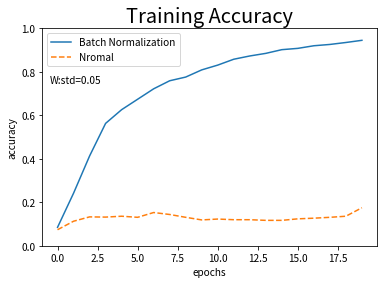

In [39]:
# 作図用のx軸の値
epochs = np.arange(max_epochs)

# 作図
plt.plot(epochs, bn_train_acc_list, label="Batch Normalization") # 正規化あり
plt.plot(epochs, train_acc_list, label="Nromal", linestyle="--") # 正規化なし
plt.ylim(0, 1) # y軸の範囲
plt.xlabel("epochs") # x軸ラベル
plt.ylabel("accuracy") # y軸ラベル
plt.title("Training Accuracy", fontsize=20) # タイトル
plt.text(-0.5, 0.75, "W:std=" + str(np.round(weight_init_std, 3))) # メモ
plt.legend() # 凡例
plt.show()

## 6.4 正則化

ここでは、過学習を抑制するテクニックについて学びます。

### 6.4.1 過学習

過学習の主な原因として以下が挙げられます。
- データに対し、パラーメータが多すぎる
- 訓練データが少ない
この二つの要件を満たし、恣意的に過学習を起こしてみます。MNISTデータセットの訓練データを300枚に限定させ、7層のニューラルネットワークを用います。

In [40]:
# 学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# 訓練データ数
train_size = x_train.shape[0]

# バッチサイズを指定
batch_size = 100

In [41]:
# 荷重減衰の係数を指定
weight_decay_lambda = 0

# 7層のニューラルネットワークのインスタンスを作成
network = MultiLayerNet(
    input_size=784, 
    hidden_size_list=[100, 100, 100, 100, 100, 100], 
    output_size=10, 
    activation='relu', # 活性化関数
    weight_init_std='he', # 重みの初期値の標準偏差
    weight_decay_lambda=weight_decay_lambda # 荷重減衰の係数
)

# 最適化手法を指定
optimizer = SGD(lr=0.01)

In [42]:
# エポック当たりの試行回数を指定
max_epochs = 201

# 全データ数に対するバッチデータ数の割合(エポック数判定用)
iter_per_epoch = max(train_size / batch_size, 1)

# 試行回数のカウントを初期化
epoch_cnt = 0

# 認識精度の受け皿を初期化
train_loss_list = []
train_acc_list = []
test_acc_list = []

for i in range(1000000000):
    
    # ランダムにバッチデータ抽出
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配を計算
    grads = network.gradient(x_batch, t_batch)
    
    # パラメータを更新
    optimizer.update(network.params, grads)
    
    # 1エポックごとに認識精度を測定
    if i % iter_per_epoch == 0:
        # 認識精度を測定
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        
        # 値を記録
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        # 損失関数を計算
        train_loss = network.loss(x_train, t_train)
        
        # 値を記録
        train_loss_list.append(train_loss)
        
        # (動作確認も兼ねて)10エポックごとに認識精度を表示
        if epoch_cnt % 10 == 0:
            print(
                "===========" + "epoch:" + str(epoch_cnt) + "===========" + 
                "\ntrain acc:" + str(np.round(train_acc, 3)) + 
                "\ntest acc :" + str(np.round(test_acc, 3))
            )
        
        # エポック数をカウント
        epoch_cnt += 1
        
        # 最大エポック数に達すると終了
        if epoch_cnt >= max_epochs:
            break

===========epoch:0===========
train acc:0.093
test acc :0.099
===========epoch:10===========
train acc:0.317
test acc :0.203
===========epoch:20===========
train acc:0.45
test acc :0.295
===========epoch:30===========
train acc:0.653
test acc :0.477
===========epoch:40===========
train acc:0.743
test acc :0.567
===========epoch:50===========
train acc:0.817
test acc :0.643
===========epoch:60===========
train acc:0.893
test acc :0.688
===========epoch:70===========
train acc:0.923
test acc :0.701
===========epoch:80===========
train acc:0.947
test acc :0.719
===========epoch:90===========
train acc:0.963
test acc :0.732
===========epoch:100===========
train acc:0.977
test acc :0.743
===========epoch:110===========
train acc:0.983
test acc :0.747
===========epoch:120===========
train acc:0.987
test acc :0.752
===========epoch:130===========
train acc:0.987
test acc :0.754
===========epoch:140===========
train acc:0.993
test acc :0.755
===========epoch:150===========
train acc:1.0
test a

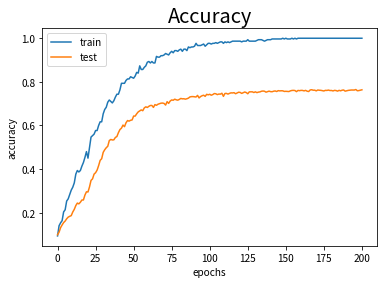

In [43]:
# 作図用のx軸の値
epoch_vec = np.arange(max_epochs)

# 作図
plt.plot(epoch_vec, train_acc_list, label='train') # 訓練データ
plt.plot(epoch_vec, test_acc_list, label='test') # テストデータ
plt.xlabel("epochs") # x軸ラベル
plt.ylabel("accuracy") # y軸ラベル
plt.title("Accuracy", fontsize=20) # タイトル
plt.legend() # 凡例
plt.show()

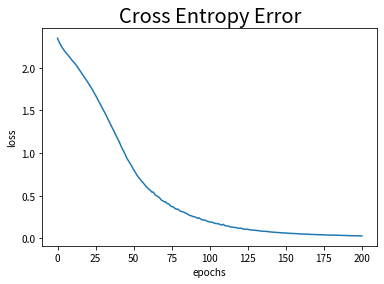

In [44]:
# 作図用のx軸の値
epoch_vec = np.arange(max_epochs)

# 作図
plt.plot(epoch_vec, train_loss_list)
plt.xlabel("epochs") # x軸ラベル
plt.ylabel("loss") # y軸ラベル
plt.title("Cross Entropy Error", fontsize=20) # タイトル
plt.show()

### 6.4.2 Weight decay

ニューラルネットワークの学習では、確率的勾配降下法によって損失関数の値
L
が小さくなるようにパラメータを更新するのでした。そこで損失関数(の計算)に、重みの値が大きいと損失関数の値も大きくなるように
1
2
λ
W
2
を加えることにします。これによって、交差エントロピー誤差とともに
1
2
λ
W
2
(つまり重み)を小さくするように学習します。

　重み
W
の要素は負の値にもなるので2乗しているわけですね。
λ
は正則化の強さを調整するハイパーパラメータです。
λ
が小さいほど
W
2
が割り引かれるので、重みの影響が弱くなります。誤差逆伝播法では損失関数の勾配、つまり微分を伝播するのでした。
1
2
は、
1
2
λ
W
2
を
W
で微分したときに項を扱いやすくする(指数の2を打ち消す)ための定数項です。

　従って逆伝播では
λ
W
を伝播します。
MultiLayerNetの実装おいてどのように正則化処理を行うのか確認しておきます。


　簡単なMultiLayerNetのインスタンスを作成します。このクラスには既にWeight decayが実装されていますが、同じ処理を再現してみます。

In [45]:
# 4層のニューラルネットワークのインスタンスを作成
network = MultiLayerNet(
    input_size=784, 
    hidden_size_list=[10, 10, 10], 
    output_size=10, 
    activation='relu', # 活性化関数
    weight_init_std='he', # 重みの初期値の標準偏差
)

# 最適化手法を指定
optimizer = SGD(lr=0.01)

In [46]:
# ニューラルネットワークの計算
y = network.predict(x_train)

# 最終層の重みを確認
print(np.round(network.params['W4'], 2))

[[ 0.68  0.28  0.19  0.2  -0.06  0.7  -0.76  1.04  1.11  0.3 ]
 [-0.16 -0.01 -0.51  0.14 -0.21  0.27 -0.19  0.27  0.41 -0.01]
 [ 0.06  1.31  0.55 -0.69 -0.31 -0.11  0.04  0.79 -0.87  0.42]
 [ 0.15 -0.33 -0.31  0.47  1.16  0.31 -0.21 -0.2   0.18 -0.47]
 [ 0.54 -0.19  0.88 -0.17  0.1  -0.3   0.19 -0.17 -0.85 -0.11]
 [-0.45  0.27  0.82  0.38  0.64 -0.31  0.77  0.23  0.52  0.32]
 [-0.22 -0.04 -0.49  0.48 -0.06  0.81 -0.08  0.35  0.14  0.35]
 [-0.34 -1.07  0.06 -0.34 -0.04  0.09  0.48  0.25  0.29  0.38]
 [-0.09  0.71  0.14 -0.11  0.64  0.29 -0.01 -0.05  0.55 -0.57]
 [-0.58 -0.61 -0.26 -0.04  0.19  0.53  0.01 -0.49  0.12 -0.32]]


In [47]:
# 荷重減衰の係数を指定
weight_decay_lambda = 0.1

# 荷重減衰を初期化
weight_decay = 0
for i in range(1, network.hidden_layer_num + 2):
    # 重みを複製
    W = network.params['W' + str(i)]
    
    # Weight decay(荷重減衰)を計算
    weight_decay += 0.5 * weight_decay_lambda * np.sum(W ** 2)

print(weight_decay)

3.873722438295168


In [48]:
# L2正則化版損失関数の計算
loss = network.last_layer.forward(y, t_train) + weight_decay
print(loss)


6.210994733307593


In [49]:
# 荷重減衰の係数を指定
weight_decay_lambda = 0.1

# 7層のニューラルネットワークのインスタンスを作成
network = MultiLayerNet(
    input_size=784, 
    hidden_size_list=[100, 100, 100, 100, 100, 100], 
    output_size=10, 
    activation='relu', # 活性化関数
    weight_init_std='he', # 重みの初期値の標準偏差
    weight_decay_lambda=weight_decay_lambda# 荷重減衰の係数
)

# 最適化手法を指定
optimizer = SGD(lr=0.01)

In [50]:
# エポック当たりの試行回数を指定
max_epochs = 201

# 全データ数に対するバッチデータ数の割合(エポック数判定用)
iter_per_epoch = max(train_size / batch_size, 1)

# 試行回数のカウントを初期化
epoch_cnt = 0

# 認識精度の受け皿を初期化
train_loss_list = []
train_acc_list = []
test_acc_list = []

for i in range(1000000000):
    # ランダムにバッチデータ抽出
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配を計算
    grads = network.gradient(x_batch, t_batch)
    
    # パラメータを更新
    optimizer.update(network.params, grads)
    
    # 1エポックごとに認識精度を測定
    if i % iter_per_epoch == 0:
        # 認識精度を測定
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        
        # 値を記録
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        # 損失関数を計算
        train_loss = network.loss(x_train, t_train)
        
        # 値を記録
        train_loss_list.append(train_loss)
        
        # (動作確認も兼ねて)10エポックごとに認識精度を表示
        if epoch_cnt % 10 == 0:
            print(
                "===========" + "epoch:" + str(epoch_cnt) + "===========" + 
                "\ntrain acc:" + str(np.round(train_acc, 3)) + 
                "\ntest acc :" + str(np.round(test_acc, 3))
            )
        
        # エポック数をカウント
        epoch_cnt += 1
        
        # 最大エポック数に達すると終了
        if epoch_cnt >= max_epochs:
            break

===========epoch:0===========
train acc:0.077
test acc :0.113
===========epoch:10===========
train acc:0.343
test acc :0.272
===========epoch:20===========
train acc:0.547
test acc :0.427
===========epoch:30===========
train acc:0.667
test acc :0.518
===========epoch:40===========
train acc:0.753
test acc :0.592
===========epoch:50===========
train acc:0.79
test acc :0.628
===========epoch:60===========
train acc:0.817
test acc :0.658
===========epoch:70===========
train acc:0.84
test acc :0.678
===========epoch:80===========
train acc:0.853
test acc :0.694
===========epoch:90===========
train acc:0.877
test acc :0.693
===========epoch:100===========
train acc:0.88
test acc :0.718
===========epoch:110===========
train acc:0.883
test acc :0.726
===========epoch:120===========
train acc:0.897
test acc :0.728
===========epoch:130===========
train acc:0.903
test acc :0.727
===========epoch:140===========
train acc:0.9
test acc :0.726
===========epoch:150===========
train acc:0.887
test acc

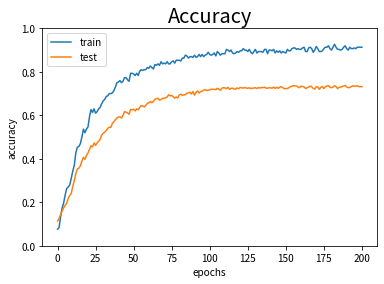

In [51]:
# 作図用のx軸の値
epoch_vec = np.arange(max_epochs)

# 作図
plt.plot(epoch_vec, train_acc_list, label='train') # 訓練データ
plt.plot(epoch_vec, test_acc_list, label='test') # テストデータ
plt.ylim(0, 1) # y軸の範囲
plt.xlabel("epochs") # x軸ラベル
plt.ylabel("accuracy") # y軸ラベル
plt.title("Accuracy", fontsize=20) # タイトル
plt.legend() # 凡例
plt.show()

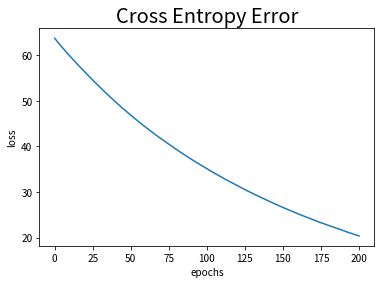

In [52]:
# 作図用のx軸の値
epoch_vec = np.arange(max_epochs)

# 作図
plt.plot(epoch_vec, train_loss_list)
plt.xlabel("epochs") # x軸ラベル
plt.ylabel("loss") # y軸ラベル
plt.title("Cross Entropy Error", fontsize=20) # タイトル
plt.show()

### 6.4.3 Dropout

In [53]:
# バッチサイズを指定
batch_size = 5

# ニューロン数を指定
node_num = 5

# (処理のイメージ用に)ランダムに整数を生成
x = np.random.randint(0, 10, (batch_size, node_num))
print(x)

[[4 6 5 4 6]
 [7 3 1 7 4]
 [1 8 3 9 5]
 [5 8 5 9 9]
 [1 2 1 0 0]]


In [54]:
# Dropout ratioを指定
dropout_ratio = 0.5

# ランダムに0から1の値を生成
random_data = np.random.rand(*x.shape)
print(np.round(random_data, 3))

# 一定の値以上の要素を検索
mask = random_data > dropout_ratio
print(mask)

[[0.903 0.954 0.383 0.626 0.069]
 [0.421 0.151 0.485 0.972 0.303]
 [0.987 0.411 0.428 0.136 0.125]
 [0.043 0.219 0.695 0.728 0.71 ]
 [0.475 0.541 0.361 0.007 0.279]]
[[ True  True False  True False]
 [False False False  True False]
 [ True False False False False]
 [False False  True  True  True]
 [False  True False False False]]


In [55]:
# ノードを消去
print(x * mask)

[[4 6 0 4 0]
 [0 0 0 7 0]
 [1 0 0 0 0]
 [0 0 5 9 9]
 [0 2 0 0 0]]


In [56]:
# Dropoutの実装
class Dropout:
    
    # インスタンスの定義
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    # 順伝播メソッドの定義
    def forward(self, x, train_flg=True):
        # ランダムにニューロンを消去
        if train_flg: # 訓練時
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else: # テスト時
            return x * (1.0 - self.dropout_ratio)
    
    # 逆伝播メソッドの定義
    def backward(self, dout):
        return dout * self.mask

In [57]:
# 学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# 訓練データ数
train_size = x_train.shape[0]

# バッチサイズを指定
batch_size = 100

In [58]:
# 消去するニューロンの割合を指定
dropout_ratio = 0.0

# 7層のニューラルネットワークのインスタンスを作成
network = MultiLayerNetExtend(
    input_size=784, 
    hidden_size_list=[100, 100, 100, 100, 100, 100], 
    output_size=10, 
    activation='relu', # 活性化関数
    weight_init_std='he', # 重みの初期値の標準偏差
    use_dropout=False, # Dropoutの設定
    dropout_ration=dropout_ratio # ニューロンを消去する割合
)

# 最適化手法を指定
optimizer = SGD(lr=0.01)

In [59]:
# エポック当たりの試行回数を指定
max_epochs = 301

# 全データ数に対するバッチデータ数の割合(エポック数判定用)
iter_per_epoch = max(train_size / batch_size, 1)

# 試行回数のカウントを初期化
epoch_cnt = 0

# 認識精度の受け皿を初期化
train_acc_list = []
test_acc_list = []

for i in range(1000000000):
    # ランダムにバッチデータ抽出
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配を計算
    grads = network.gradient(x_batch, t_batch)
    
    # パラメータを更新
    optimizer.update(network.params, grads)
    
    # 1エポックごとに認識精度を測定
    if i % iter_per_epoch == 0:
        # 認識精度を測定
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        
        # 値を記録
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        # (動作確認も兼ねて)10エポックごとに認識精度を表示
        if epoch_cnt % 10 == 0:
            print(
                "===========" + "epoch:" + str(epoch_cnt) + "===========" + 
                "\ntrain acc:" + str(np.round(train_acc, 3)) + 
                "\ntest acc :" + str(np.round(test_acc, 3))
            )
        
        # エポック数をカウント
        epoch_cnt += 1
        
        # 最大エポック数に達すると終了
        if epoch_cnt >= max_epochs:
            break

===========epoch:0===========
train acc:0.117
test acc :0.126
===========epoch:10===========
train acc:0.25
test acc :0.192
===========epoch:20===========
train acc:0.45
test acc :0.316
===========epoch:30===========
train acc:0.607
test acc :0.451
===========epoch:40===========
train acc:0.727
test acc :0.57
===========epoch:50===========
train acc:0.79
test acc :0.633
===========epoch:60===========
train acc:0.877
test acc :0.688
===========epoch:70===========
train acc:0.903
test acc :0.705
===========epoch:80===========
train acc:0.933
test acc :0.717
===========epoch:90===========
train acc:0.943
test acc :0.728
===========epoch:100===========
train acc:0.96
test acc :0.727
===========epoch:110===========
train acc:0.98
test acc :0.736
===========epoch:120===========
train acc:0.997
test acc :0.743
===========epoch:130===========
train acc:1.0
test acc :0.744
===========epoch:140===========
train acc:1.0
test acc :0.75
===========epoch:150===========
train acc:1.0
test acc :0.751


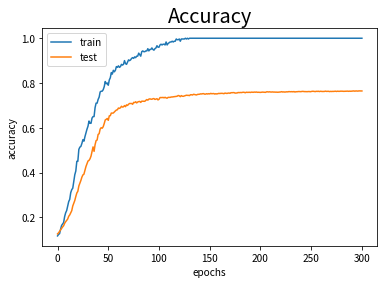

In [60]:
# 作図用のx軸の値
epoch_vec = np.arange(max_epochs)

# 作図
plt.plot(epoch_vec, train_acc_list, label='train') # 訓練データ
plt.plot(epoch_vec, test_acc_list, label='test') # テストデータ
#plt.ylim(0, 1) # y軸の範囲
plt.xlabel("epochs") # x軸ラベル
plt.ylabel("accuracy") # y軸ラベル
plt.title("Accuracy", fontsize=20) # タイトル
plt.legend() # 凡例
plt.show()

In [61]:
# 消去するニューロンの割合を指定
dropout_ratio = 0.15

# 7層のニューラルネットワークのインスタンスを作成
network = MultiLayerNetExtend(
    input_size=784, 
    hidden_size_list=[100, 100, 100, 100, 100, 100], 
    output_size=10, 
    activation='relu', # 活性化関数
    weight_init_std='he', # 重みの初期値の標準偏差
    use_dropout=True, # Dropoutの設定
    dropout_ration=dropout_ratio # ニューロンを消去する割合
)

## 6.5 ハイパーパラメータ

### 6.5.1 検証データ

In [62]:
# 順番に並んだデータを生成
x = np.arange(10) * 10
print(x)

# ランダムに並び替えた要素のインデックスを生成
idx = np.random.permutation(x.shape[0])
print(idx)

# データを並び替え
x = x[idx]
print(x)

[ 0 10 20 30 40 50 60 70 80 90]
[9 2 8 4 6 7 3 1 0 5]
[90 20 80 40 60 70 30 10  0 50]


In [63]:
# 順番に並んだデータを生成
x = np.arange(10) * 10
print(x)

# ランダムに並び替え
x = np.random.permutation(x)
print(x)

[ 0 10 20 30 40 50 60 70 80 90]
[90 50 60  0 10 80 20 70 40 30]


In [64]:
# 画像データを読み込む
(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True, one_hot_label=True)

# ランダムにインデックスを生成
idx = np.random.permutation(x_train.shape[0])

# データを並べ替え
x_train = x_train[idx]
t_train = t_train[idx]
print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [65]:
# 検証データの割合を指定
validation_rate = 0.2

# 検証データ数を計算
validation_num = int(x_train.shape[0] * validation_rate)
print(validation_num)

# 検証データを抽出
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
print(x_val.shape)
print(t_val.shape)

# 訓練データを抽出
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]
print(x_train.shape)
print(t_train.shape)

12000
(12000, 784)
(12000, 10)
(48000, 784)
(48000, 10)


### 6.5.2 ハイパーパラメータの最適化

### 6.5.3 ハイパーパラメータ最適化の実装

In [66]:
# エポックあたりの試行回数を指定
max_epoch = 50

# ミニバッチサイズを指定
batch_size = 100

# 高速化のため訓練データの削減
x_train = x_train[:500]
t_train = t_train[:500]

# 訓練データ数
train_size = x_train.shape[0]

# 全データ数に対するバッチデータ数の割合
iter_per_epoch = max(train_size / batch_size, 1)
print(iter_per_epoch)

# 試行回数を計算
max_iter = int(max_epoch * iter_per_epoch)
print(max_iter)

5.0
250


In [67]:
# ハイパーパラメータの範囲を指定してランダムに値を生成
weight_decay_lambda = 10 ** np.random.uniform(-8, -4) # 荷重減衰の係数
lr = 10 ** np.random.uniform(-6, -2) # 学習率
print(weight_decay_lambda)
print(lr)

6.143955007012395e-05
0.001125518332834239


In [68]:
# 7層のニューラルネットワークのインスタンスを作成
network = MultiLayerNet(
    input_size=784, 
    hidden_size_list=[100, 100, 100, 100, 100, 100], 
    output_size=10, 
    activation='relu', # 活性化関数
    weight_init_std='he', # 重みの初期値の標準偏差
    weight_decay_lambda=weight_decay_lambda # 荷重減衰の係数
)

# 最適化手法を指定
optimizer = SGD(lr=0.01)

In [69]:
# 認識精度の受け皿を初期化
val_acc_list = []
train_acc_list = []

# ミニバッチデータごとに処理
for i in range(max_iter):
    
    # ランダムにバッチデータを抽出
    batch_mask = np.random.choice(train_size, batch_size, replace=False)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配を計算
    grads = network.gradient(x_batch, t_batch)
    
    # パラメータを更新
    optimizer.update(network.params, grads)
    
    # エポックごとに認識精度を測定
    if i % iter_per_epoch == 0:
        # 認識精度を測定
        val_acc = network.accuracy(x_val, t_val)
        train_acc = network.accuracy(x_train, t_train)
        
        # 値を記録
        val_acc_list.append(val_acc)
        train_acc_list.append(train_acc)
        
# (動作確認も兼ねて)認識精度を表示
print(
    "=============== Result ===============" + 
    "\nlr:" + str(lr) + ", lambda:" + str(weight_decay_lambda) + 
    "\nval acc  " + ":" + str(np.round(val_acc, 5)) + 
    "\ntrain acc" + ":" + str(np.round(train_acc, 5))
)

=============== Result ===============
lr:0.001125518332834239, lambda:6.143955007012395e-05
val acc  :0.80058
train acc:0.96


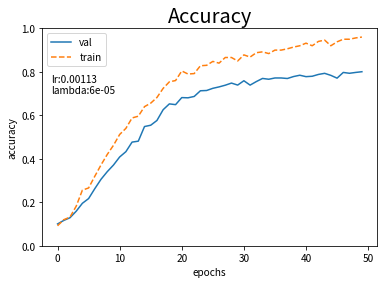

In [70]:
# 作図用のx軸の値
epochs = np.arange(max_epoch)

# 作図
plt.plot(epochs, val_acc_list, label='val') # 訓練データ
plt.plot(epochs, train_acc_list, label='train', linestyle='--') # テストデータ
plt.ylim(0, 1) # y軸の範囲
plt.xlabel("epochs") # x軸ラベル
plt.ylabel("accuracy") # y軸ラベル
plt.title("Accuracy", fontsize=20) # タイトル
plt.text(-1, 0.7, "lr:" + str(np.round(lr, 5)) + "\nlambda:" + str(np.round(weight_decay_lambda, 5))) # メモ
plt.legend() # 凡例
plt.show()